In [144]:
import matplotlib.pyplot as plt

In [145]:
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

### Data Collection

In [146]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_exercise_train.csv')
download_file(test_data_url, 'module5_exercise_test.csv')

Downloaded module5_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv
Downloaded module5_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv


In [147]:
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")
df_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [148]:
df_train.isna().sum()

date                           0
weather_condition             24
humidity                      96
wind_speed                    90
oil_brent_price_indicator      0
temperature_station1         285
temperature_station2         275
temperature_station3         289
temperature_station4         277
temperature_station5         279
temperature_station6         273
temperature_station7         308
temperature_station8         282
temperature_station9         288
temperature_station10        316
electricity_demand             0
dtype: int64

### Data analysis

In [149]:
#### Make a complete analysis on data preprocessing
# Inconsistencies
# Duplicates (data.duplicated().sum())
# Missing values (data.isnull().sum())
# Categorical
# Outliers
# Feature Engineering
# Feature Selection and/or Dimensionality Reduction

In [154]:
def plot_feature_over_time(df, feature, date_id_start, date_id_end):
    df_filtered = df[(df['date'] >= date_id_start) & (df['date'] <= date_id_end)]
    
    if feature not in df_filtered.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['date'], df_filtered[feature], label=feature, linestyle='-')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} from {date_id_start} to {date_id_end}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



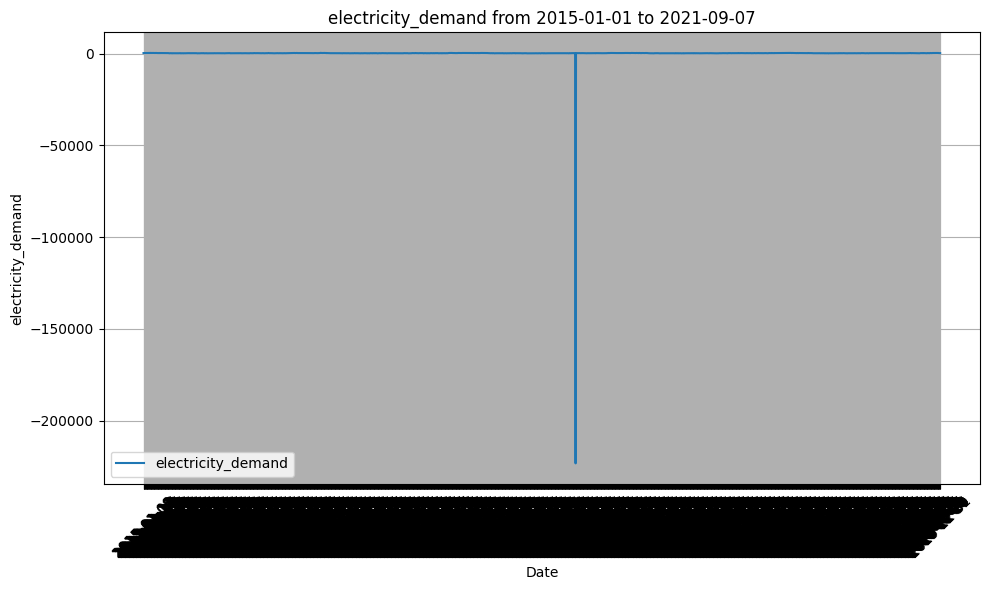

In [155]:
plot_feature_over_time(data, 'electricity_demand', '2015-01-01', '2021-09-07')

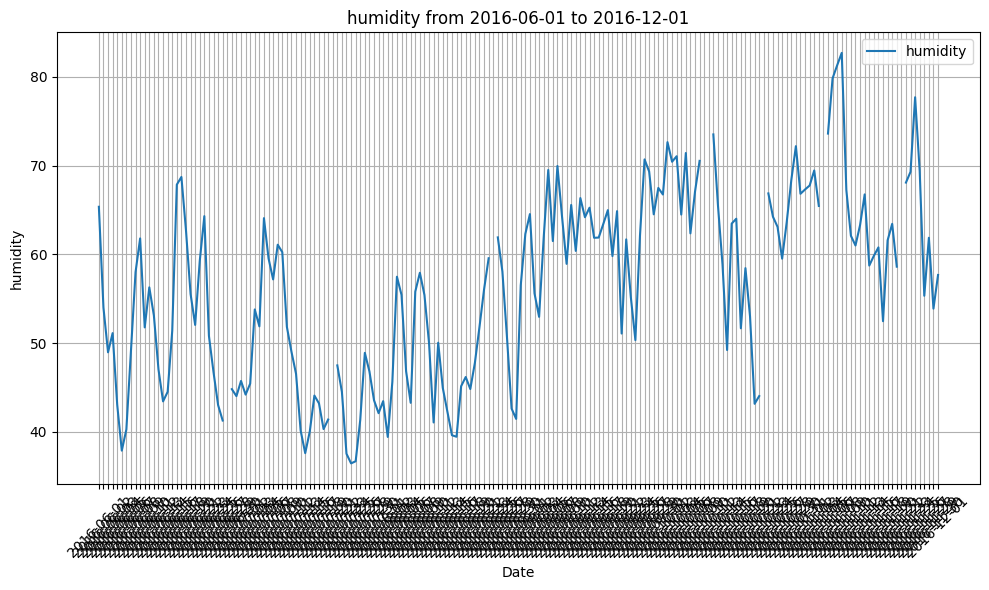

In [156]:
plot_feature_over_time(data, 'humidity', '2016-06-01', '2016-12-01')

### Data Preprocessing Evaluation Strategy

In [157]:
# Provide a complete data preprocessing transformations
df_test.isna().sum()

date                          0
weather_condition             4
humidity                     13
wind_speed                   17
oil_brent_price_indicator     0
temperature_station1         59
temperature_station2         53
temperature_station3         51
temperature_station4         43
temperature_station5         58
temperature_station6         48
temperature_station7         53
temperature_station8         54
temperature_station9         62
temperature_station10        51
dtype: int64

In [ ]:
#Conversion vitesse du vent en float km/h
def to_m_s(value):
    if isinstance(value, str):
        value = value.strip()
        if 'm/s' in value:
            num = float(value.replace(' m/s', '').strip())
            return num * 3.6
        elif 'km/h' in value:
            num = float(value.replace(' km/h', '').strip())
            return num
    return None  # si ce n'est pas une string ou format inconnu


df_train.head()


,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.740,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.780,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,24.588,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,20.844,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.140,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090


In [223]:
# 1. Handle Inconsistencies
def handle_inconsistencies(X_train, y_train, X_val=None):
    X_train = X_train.copy()
    y_train = y_train.copy()
    X_train['wind_speed'] = X_train['wind_speed'].apply(to_m_s)
    if X_val is not None:
        X_val = X_val.copy()
        X_val['wind_speed'] = X_val['wind_speed'].apply(to_m_s)
        return X_train, y_train, X_val
    else:
        return X_train, y_train
    


def handle_duplicates(X_train, y_train, X_val=None):
    """
    Supprime les doublons exacts dans X_train (et garde la première occurrence).
    """
    X_train = X_train.copy()
    y_train = y_train.copy()
    if X_val is not None:
        X_val = X_val.copy()

    # Supprimer les doublons
    duplicates_mask = X_train.duplicated(keep='first')
    X_train_no_duplicates = X_train[~duplicates_mask]
    y_train_no_duplicates = y_train.loc[X_train_no_duplicates.index]

    if X_val is not None:
        return X_train_no_duplicates, y_train_no_duplicates, X_val
    else:
        return X_train_no_duplicates, y_train_no_duplicates

from sklearn.impute import SimpleImputer

# 3. Handling Missing Values
def handle_missing_values(X_train, y_train = None, X_val=None):
    numerical_cols = X_train.select_dtypes(include=['number']).columns
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
    imputer = SimpleImputer(strategy='mean')
    X_train[numerical_cols] = imputer.fit_transform(X_train[numerical_cols])

    # Imputation des catégorielles avec le mode
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])

    y_train = y_train.copy()
    imputery = SimpleImputer(strategy='mean')
    y_train = imputery.fit_transform(y_train.to_frame()).ravel() 

    if X_val is not None:
        X_val[numerical_cols] = imputer.transform(X_val[numerical_cols])
        X_val[cat_cols] = cat_imputer.transform(X_val[cat_cols])  
        return X_train.copy(), y_train, X_val.copy()
    else:

        return X_train.copy(), y_train

# 4. Handling Categorical Values
def handle_categorical(X_train, y_train, X_val=None):
    X_train = X_train.copy()
    X_train = pd.get_dummies(X_train, drop_first=False)  
    if X_val is not None:
        X_val = X_val.copy()
        X_val = pd.get_dummies(X_val, drop_first=False)
        return X_train.copy(), X_val.copy()
    else:
        return X_train.copy()

# 5. Handling Outliers


# 6. Feature Engineering
def feature_engineering(X_train, y_train, X_val=None):
    #Feature Engineering
    # 1. Convertir en datetime
    X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')

    # 2. Créer une colonne binaire : 1 = week-end, 0 = jour de semaine
    X_train['is_weekend'] = X_train['date'].dt.dayofweek >= 5

    # Optionnel : transformer en int (0 ou 1)
    X_train['is_weekend'] = X_train['is_weekend'].astype(int)

    X_train.drop('date', axis=1, inplace=True)
   
    if X_val is not None:

        X_val['date'] = pd.to_datetime(X_val['date'], format='%Y-%m-%d')  
        X_val['is_weekend'] = X_val['date'].dt.dayofweek >= 5
        X_val['is_weekend'] = X_val['is_weekend'].astype(int)
        X_val.drop('date', axis=1, inplace=True)
        return X_train.copy(), y_train, X_val.copy()
    else:
        return X_train.copy(), y_train

# 7. Feature Selection and Dimensionality Reduction
def feature_selection(X_train, y_train, X_val=None):
    selected_columns = ['humidity', 'temperature_station1',
       'temperature_station2', 'temperature_station3', 'temperature_station4',
       'temperature_station5', 'temperature_station6', 'temperature_station7',
       'temperature_station8', 'temperature_station9', 'temperature_station10']
    if X_val is not None:
        return X_train[selected_columns], X_val[selected_columns]
    else:
        return X_train[selected_columns]

In [199]:


def handle_outliers(X_train, y_train=None, X_val=None):
    X_train = X_train.copy()
    if y_train is not None:
        y_train = y_train.copy()
    if X_val is not None:
        X_val = X_val.copy()
    
    numeric_cols = X_train.select_dtypes(include='number').columns

    # Boucle sur chaque colonne numérique
    for col in numeric_cols:
        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Remplacer les outliers par NaN
        X_train[col] = X_train[col].mask((X_train[col] < lower) | (X_train[col] > upper))

    # Même traitement pour y si c'est une Series
    if y_train is not None and isinstance(y_train, pd.Series):
        Q1 = y_train.quantile(0.25)
        Q3 = y_train.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        y_train = y_train.mask((y_train < lower) | (y_train > upper))

    if X_val is not None:
        return X_train, y_train, X_val
    else:
        return X_train, y_train


In [162]:
numerical_cols = df_train.select_dtypes(include='number').columns.drop('electricity_demand')
cat_cols = df_train.select_dtypes(include='object').columns

X = df_train.drop('electricity_demand', axis=1)
X_test = df_test.copy()
#X_cat_cols = df_train[cat_cols]
y = df_train['electricity_demand']

X, y = handle_outliers(X, y)


In [163]:
X 

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10
0,2015-01-08,Cloudy,69.304377,27.740,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661
1,2015-01-09,Sunny,55.955975,21.780,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365
2,2015-01-10,Rainy,62.701614,24.588,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883
3,2015-01-11,Snowy,60.375001,20.844,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN
4,2015-01-12,Snowy,NaN,25.140,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,2019-12-27,Snowy,71.521673,22.780,Moderate,-1.674798,-2.338987,-1.829170,-0.881428,-0.571347,-2.231680,-1.962735,-1.602805,-1.264779,-1.705180
1904,2019-12-28,Sunny,67.220123,18.330,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638
1905,2019-12-29,Rainy,68.085227,26.064,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333
1906,2019-12-29,Rainy,68.085227,26.064,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333


In [174]:
def evaluate_pipeline(X, y, n_splits=5):

    ### call transformations here, if there is no learning and no need to be crossval
    X, y = handle_inconsistencies(X, y)
    # X, y = handle_duplicates(X, y)
    X  = handle_missing_values(X, y)
    # X_train = handle_categorical(X, y)
    X, y = handle_outliers(X, y)
    # X, y = feature_engineering(XX, y)
    X = feature_selection(X, y)
    
    model = LinearRegression()
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    train_scores = []
    val_scores = []
    
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Processing fold {fold + 1}/{n_splits}...")
        
        # Split data into train and validation sets
        X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

        ### call transformations here, if there is learning
        # X_train, y_train, X_val = handle_inconsistencies(X_train, y_train, X_val)
        X_train, y_train, X_val = handle_duplicates(X_train, y_train, X_val)
        # X_train, X_val = handle_missing_values(X_train, y_train, X_val)
        X_train, X_val = handle_categorical(X_train, y_train, X_val)
        # X_train, y_train, X_val = handle_outliers(X_train, y_train, X_val)
        X_train, y_train, X_val = feature_engineering(X_train, y_train, X_val)
        # X_train, X_val = feature_selection(X_train, y_train, X_val)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_scores.append(train_mse)
        
        # Predict on validation set
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_scores.append(val_mse)
        
        print(f"Fold {fold + 1} Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
    
    # Compute mean, max, and min values for train and validation MSE
    mean_train_mse = np.mean(train_scores)
    max_train_mse = np.max(train_scores)
    min_train_mse = np.min(train_scores)
    
    mean_val_mse = np.mean(val_scores)
    max_val_mse = np.max(val_scores)
    min_val_mse = np.min(val_scores)
    
    # Print results
    print("\nTrain MSE:")
    print(f"Mean: {mean_train_mse:.4f}, Max: {max_train_mse:.4f}, Min: {min_train_mse:.4f}")
    
    print("\nValidation MSE:")
    print(f"Mean: {mean_val_mse:.4f}, Max: {max_val_mse:.4f}, Min: {min_val_mse:.4f}")
    
    return mean_val_mse  # Return mean validation MSE as the overall score

In [22]:
# Prepare X and y
X = df_train.copy().drop(columns=['electricity_demand'], axis=1)
y = df_train.copy().pop('electricity_demand')

# Run the evaluation
evaluate_pipeline(X, y)

Processing fold 1/5...
Fold 1 Train MSE: 1198.2910, Validation MSE: 1591.4458
Processing fold 2/5...
Fold 2 Train MSE: 1364.6326, Validation MSE: 1376.3577
Processing fold 3/5...
Fold 3 Train MSE: 1318.7249, Validation MSE: 157358182.6667
Processing fold 4/5...
Fold 4 Train MSE: 39175684.8609, Validation MSE: 99701.3186
Processing fold 5/5...
Fold 5 Train MSE: 31360575.8434, Validation MSE: 44368.0790

Train MSE:
Mean: 14108028.4706, Max: 39175684.8609, Min: 1198.2910

Validation MSE:
Mean: 31501043.9736, Max: 157358182.6667, Min: 1376.3577


31501043.97358788

In [176]:
model = LinearRegression()
model.fit(X, y)

# --- 3️⃣ Prédire sur le test ---
y_pred = model.predict(X)

# --- 4️⃣ Calculer la MSE ---
mse = mean_squared_error(y, y_pred)

In [182]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

ridge = Ridge(alpha=1.0)  # alpha = paramètre de régularisation
ridge.fit(X, y)

# Prédire et évaluer
y_pred = ridge.predict(X)
mse = mean_squared_error(y, y_pred)

In [183]:
mse

27373499.883842338

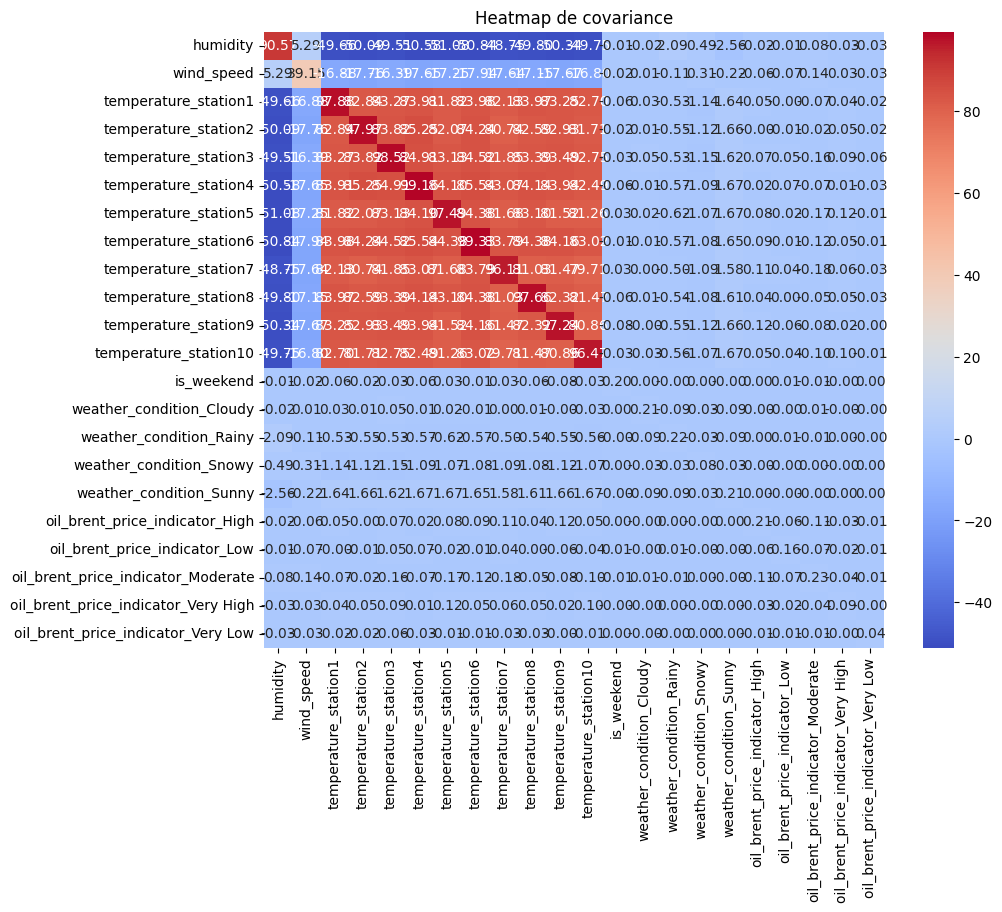

In [ ]:
import seaborn as sns

cov_matrix = X.cov()  # matrice de covariance

# Affichage heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de covariance")
plt.show()

In [ ]:
cov_matrix


,humidity,wind_speed,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,...,is_weekend,weather_condition_Cloudy,weather_condition_Rainy,weather_condition_Snowy,weather_condition_Sunny,oil_brent_price_indicator_High,oil_brent_price_indicator_Low,oil_brent_price_indicator_Moderate,oil_brent_price_indicator_Very High,oil_brent_price_indicator_Very Low
humidity,90.573523,5.288456,-49.655990,-50.085120,-49.505162,-50.584940,-51.078581,-50.836399,-48.745490,-49.798831,...,-0.005419,-0.020898,2.090431,0.486199,-2.555733,-0.022583,-0.009847,0.084864,-0.027084,-0.025350
wind_speed,5.288456,39.151027,-16.875574,-17.760723,-16.385851,-17.646455,-17.252660,-17.939075,-17.641469,-17.145701,...,-0.020597,0.014164,-0.106148,0.308077,-0.216093,-0.058308,-0.074114,0.135141,0.025581,-0.028301
temperature_station1,-49.655990,-16.875574,97.879958,82.843659,83.266030,83.914605,81.816416,83.980055,82.133546,83.969277,...,-0.063579,0.033875,-0.529034,-1.142507,1.637666,0.052804,-0.001087,-0.073112,0.039373,-0.017978
temperature_station2,-50.085120,-17.760723,82.843659,97.966960,83.816033,85.245792,82.069347,84.239218,80.739772,82.594989,...,-0.022975,0.009686,-0.545709,-1.120374,1.656397,-0.003757,-0.009804,-0.019043,0.048471,-0.015867
temperature_station3,-49.505162,-16.385851,83.266030,83.816033,98.521549,84.905837,83.129906,84.516669,81.849310,83.386700,...,-0.033919,0.054731,-0.529324,-1.145416,1.620009,0.072772,0.052615,-0.159632,0.091528,-0.057283
temperature_station4,-50.584940,-17.646455,83.914605,85.245792,84.905837,99.162804,84.101756,85.541707,83.074527,84.135548,...,-0.058587,-0.010630,-0.570981,-1.089469,1.671081,0.020134,0.072811,-0.071070,0.007226,-0.029100
temperature_station5,-51.078581,-17.252660,81.816416,82.069347,83.129906,84.101756,97.486717,84.376111,81.679081,83.095636,...,0.029386,0.020679,-0.623146,-1.069324,1.671791,0.082383,-0.018793,-0.168067,0.115829,-0.011353
temperature_station6,-50.836399,-17.939075,83.980055,84.239218,84.516669,85.541707,84.376111,99.328541,83.789359,84.384794,...,-0.011849,-0.009436,-0.569685,-1.075186,1.654308,0.094720,-0.009235,-0.120675,0.045226,-0.010036
temperature_station7,-48.745490,-17.641469,82.133546,80.739772,81.849310,83.074527,81.679081,83.789359,96.106998,81.030671,...,0.026261,0.004707,-0.495004,-1.093787,1.584084,0.108089,0.037788,-0.175269,0.061845,-0.032453
temperature_station8,-49.798831,-17.145701,83.969277,82.594989,83.386700,84.135548,83.095636,84.384794,81.030671,97.662726,...,-0.059657,0.009916,-0.542678,-1.076171,1.608933,0.035255,0.003278,-0.054267,0.048912,-0.033177


In [177]:
mse

27373499.2073104

In [175]:
evaluate_pipeline(X, y)

Processing fold 1/5...
Fold 1 Train MSE: 1069.0423, Validation MSE: 1519.8154
Processing fold 2/5...
Fold 2 Train MSE: 1251.2003, Validation MSE: 1306.2679
Processing fold 3/5...
Fold 3 Train MSE: 1216.4430, Validation MSE: 166566690.5457
Processing fold 4/5...
Fold 4 Train MSE: 41411096.7136, Validation MSE: 202196.4003
Processing fold 5/5...
Fold 5 Train MSE: 33170461.4843, Validation MSE: 71428.9689

Train MSE:
Mean: 14917018.9767, Max: 41411096.7136, Min: 1069.0423

Validation MSE:
Mean: 33368628.3996, Max: 166566690.5457, Min: 1306.2679


33368628.39961632

### Generating Submission File

In [23]:
# Train and submit your results

In [228]:
# Prepare X_train and y_train from your data
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")

X_train = df_train.drop(columns=['electricity_demand'], axis=1)
y_train = df_train['electricity_demand']

X_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [225]:

X_train, y_train, X_test = feature_engineering(X_train, y_train, X_test)

X_train, y_train, X_test = handle_inconsistencies(X_train, y_train, X_test)
X_train, y_train, X_test = handle_outliers(X_train, y_train, X_test)

X_train, y_train, X_test = handle_duplicates(X_train, y_train, X_test)
X_train, y_train, X_test = handle_missing_values(X_train, y_train, X_test)
X_train, X_test = handle_categorical(X_train, y_train, X_test)
    #X_train, X_test = feature_selection(X_train, y_train, X_test)

In [226]:
def train_and_predict_to_submit(X_train, y_train, X_test):
    model = LinearRegression()
    
    X_train, y_train, X_test = feature_engineering(X_train, y_train, X_test)

    X_train, y_train, X_test = handle_inconsistencies(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_outliers(X_train, y_train, X_test)

    X_train, y_train, X_test = handle_duplicates(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_missing_values(X_train, y_train, X_test)
    X_train, X_test = handle_categorical(X_train, y_train, X_test)
    #X_train, X_test = feature_selection(X_train, y_train, X_test)

    # Train the model on the entire training set
    print(f"Training model on entire dataset of shape: {X_train.shape}")
    model.fit(X_train, y_train)
    
    # Predict on the test set
    print(f"Predicting on test dataset of shape: {X_test.shape}")
    y_test_pred = model.predict(X_test)
    
    return y_test_pred

In [229]:
# Call serve_model to train and predict
y_test_pred = train_and_predict_to_submit(X_train, y_train, X_test)

Training model on entire dataset of shape: (1819, 22)
Predicting on test dataset of shape: (365, 22)


In [27]:
# Generating Submission File
submission = pd.DataFrame({
    'date': X_test['date']
    'electricity_demand': y_test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False, sep=',')
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
